# Retail Sentiment Analysis - Part 2: Preprocessing & Sentiment Analysis

**Project**: Analyzing customer reviews to extract business insights

**Notebook Purpose**: Clean the text data and perform sentiment analysis using VADER

**Author**: Aranya Bhattacharyya

**Date**: January 2026

## 1. Import Libraries

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Text processing
import re
import string

# Sentiment analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Progress bar (optional but nice)
from tqdm import tqdm
tqdm.pandas()

# Settings
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("All libraries imported successfully!")

All libraries imported successfully!


## 2. Load the Dataset

In [2]:
# Load data
data_path = ('C:/Users/arany/Desktop/Projects/Amazon Product Reviews/Reviews.csv')  # UPDATE if different

df = pd.read_csv(data_path)

# Set column names (update these to match YOUR dataset)
review_column = 'Text'
rating_column = 'Score'

print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"Using columns: '{review_column}' and '{rating_column}'")

Dataset loaded: 568454 rows, 10 columns
Using columns: 'Text' and 'Score'


## 3. Data Preprocessing

We'll clean the text to improve sentiment analysis accuracy.

In [3]:
def clean_text(text):
    """
    Clean review text for sentiment analysis.
    
    Note: We keep some punctuation because VADER uses it for sentiment
    (e.g., "!!!" indicates strong emotion)
    """
    if not isinstance(text, str):
        return ""
    
    # Convert to lowercase (VADER handles this, but good practice)
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www.\S+', '', text)
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    return text

# Test the function
sample = "This is AMAZING!!! Check it out at http://example.com <br> Best product ever!!!"
print(f"Original: {sample}")
print(f"Cleaned: {clean_text(sample)}")

Original: This is AMAZING!!! Check it out at http://example.com <br> Best product ever!!!
Cleaned: this is amazing!!! check it out at best product ever!!!


In [4]:
# Apply cleaning to all reviews
print("Cleaning review text...")
df['cleaned_text'] = df[review_column].progress_apply(clean_text)

# Check results
print("\nExample of cleaned text:")
print("\nOriginal:")
print(df[review_column].iloc[0][:200])
print("\nCleaned:")
print(df['cleaned_text'].iloc[0][:200])

Cleaning review text...


100%|██████████| 568454/568454 [00:07<00:00, 74554.61it/s]


Example of cleaned text:

Original:
I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador

Cleaned:
i have bought several of the vitality canned dog food products and have found them all to be of good quality. the product looks more like a stew than a processed meat and it smells better. my labrador


In [5]:
# Remove any rows with empty reviews after cleaning
before = len(df)
df = df[df['cleaned_text'].str.len() > 0]
after = len(df)

print(f"Removed {before - after} empty reviews")
print(f"Final dataset size: {after} reviews")

Removed 13 empty reviews
Final dataset size: 568441 reviews


## 4. Sentiment Analysis with VADER

VADER (Valence Aware Dictionary and sEntiment Reasoner) is specifically designed for social media text and works well with product reviews.

In [6]:
# Initialize VADER
analyzer = SentimentIntensityAnalyzer()

# Test on sample reviews
test_reviews = [
    "This product is absolutely amazing! Best purchase ever!",
    "Terrible quality. Complete waste of money. Very disappointed.",
    "It's okay, nothing special. Does the job.",
]

print("Testing VADER on sample reviews:\n")
for review in test_reviews:
    scores = analyzer.polarity_scores(review)
    print(f"Review: {review}")
    print(f"Scores: {scores}")
    print()

Testing VADER on sample reviews:

Review: This product is absolutely amazing! Best purchase ever!
Scores: {'neg': 0.0, 'neu': 0.396, 'pos': 0.604, 'compound': 0.8794}

Review: Terrible quality. Complete waste of money. Very disappointed.
Scores: {'neg': 0.65, 'neu': 0.35, 'pos': 0.0, 'compound': -0.8516}

Review: It's okay, nothing special. Does the job.
Scores: {'neg': 0.247, 'neu': 0.546, 'pos': 0.207, 'compound': -0.092}



### Understanding VADER Scores

VADER returns 4 scores:
- **neg**: Negative sentiment (0 to 1)
- **neu**: Neutral sentiment (0 to 1)
- **pos**: Positive sentiment (0 to 1)
- **compound**: Overall sentiment (-1 to +1)

The **compound score** is most useful:
- **>= 0.05**: Positive
- **<= -0.05**: Negative
- **Between -0.05 and 0.05**: Neutral

In [7]:
# Apply VADER to all reviews
print("Analyzing sentiment for all reviews...")
print("This may take a minute or two...\n")

# Get sentiment scores
sentiment_scores = df['cleaned_text'].progress_apply(lambda x: analyzer.polarity_scores(x))

# Extract individual scores into separate columns
df['sentiment_neg'] = sentiment_scores.apply(lambda x: x['neg'])
df['sentiment_neu'] = sentiment_scores.apply(lambda x: x['neu'])
df['sentiment_pos'] = sentiment_scores.apply(lambda x: x['pos'])
df['sentiment_compound'] = sentiment_scores.apply(lambda x: x['compound'])

print("Sentiment analysis complete!")

Analyzing sentiment for all reviews...
This may take a minute or two...



100%|██████████| 568441/568441 [05:59<00:00, 1581.00it/s]


Sentiment analysis complete!


In [8]:
# Classify sentiment based on compound score
def classify_sentiment(compound_score):
    if compound_score >= 0.05:
        return 'positive'
    elif compound_score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['sentiment_label'] = df['sentiment_compound'].apply(classify_sentiment)

print("Sentiment Classification:")
print(df['sentiment_label'].value_counts())
print()
print("Percentage Distribution:")
print(df['sentiment_label'].value_counts(normalize=True) * 100)

Sentiment Classification:
sentiment_label
positive    500724
negative     55683
neutral      12034
Name: count, dtype: int64

Percentage Distribution:
sentiment_label
positive    88.087242
negative     9.795740
neutral      2.117018
Name: proportion, dtype: float64


In [9]:
# View sample results
print("Sample of sentiment analysis results:\n")
sample_df = df[[review_column, rating_column, 'sentiment_compound', 'sentiment_label']].head(10)
sample_df

Sample of sentiment analysis results:



,Text,Score,sentiment_compound,sentiment_label
0,I have bought several of the Vitality canned d...,5,0.9441,positive
1,Product arrived labeled as Jumbo Salted Peanut...,1,-0.5664,negative
2,This is a confection that has been around a fe...,4,0.8138,positive
3,If you are looking for the secret ingredient i...,2,0.4404,positive
4,Great taffy at a great price. There was a wid...,5,0.9468,positive
5,I got a wild hair for taffy and ordered this f...,4,0.8382,positive
6,This saltwater taffy had great flavors and was...,5,0.9346,positive
7,This taffy is so good. It is very soft and ch...,5,0.9487,positive
8,Right now I'm mostly just sprouting this so my...,5,0.6369,positive
9,This is a very healthy dog food. Good for thei...,5,0.8313,positive


## 5. Compare Sentiment vs. Actual Ratings

Let's see how well VADER's sentiment matches the actual star ratings.

In [10]:
# Create rating categories for comparison
def categorize_rating(rating):
    if rating >= 4:
        return 'positive'
    elif rating <= 2:
        return 'negative'
    else:
        return 'neutral'

df['rating_category'] = df[rating_column].apply(categorize_rating)

print("Rating Category Distribution:")
print(df['rating_category'].value_counts())

Rating Category Distribution:
rating_category
positive    443764
negative     82037
neutral      42640
Name: count, dtype: int64


In [11]:
# Compare sentiment vs rating
comparison = pd.crosstab(df['rating_category'], df['sentiment_label'], normalize='index') * 100

print("Sentiment vs. Rating Agreement (%):\n")
print(comparison.round(2))
print()

# Calculate agreement rate
agreement = (df['sentiment_label'] == df['rating_category']).sum()
agreement_rate = (agreement / len(df)) * 100

print(f"Overall Agreement: {agreement_rate:.2f}%")

Sentiment vs. Rating Agreement (%):

sentiment_label  negative  neutral  positive
rating_category                             
negative            39.73     5.00     55.27
neutral             17.11     3.92     78.97
positive             3.56     1.41     95.03

Overall Agreement: 80.22%


In [13]:
# Create directories if they don't exist
import os
os.makedirs('../results/figures/', exist_ok=True)
print("Created results/figures/ directory")

Created results/figures/ directory


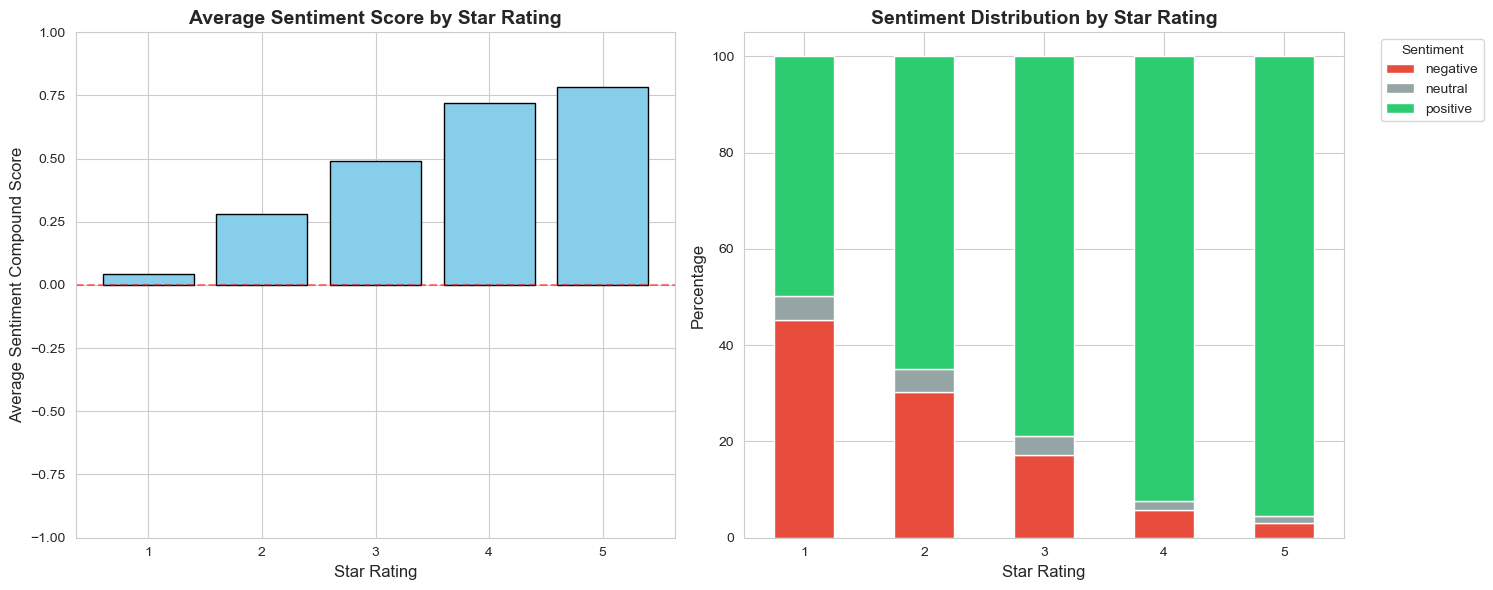

Figure saved to results/figures/sentiment_vs_rating.png


In [14]:
# Visualize sentiment by rating
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Average compound score by rating
avg_sentiment = df.groupby(rating_column)['sentiment_compound'].mean()
axes[0].bar(avg_sentiment.index, avg_sentiment.values, color='skyblue', edgecolor='black')
axes[0].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[0].set_xlabel('Star Rating', fontsize=12)
axes[0].set_ylabel('Average Sentiment Compound Score', fontsize=12)
axes[0].set_title('Average Sentiment Score by Star Rating', fontsize=14, fontweight='bold')
axes[0].set_ylim(-1, 1)

# Plot 2: Sentiment distribution by rating
sentiment_by_rating = pd.crosstab(df[rating_column], df['sentiment_label'], normalize='index') * 100
sentiment_by_rating.plot(kind='bar', stacked=True, ax=axes[1], 
                         color=['#e74c3c', '#95a5a6', '#2ecc71'])
axes[1].set_xlabel('Star Rating', fontsize=12)
axes[1].set_ylabel('Percentage', fontsize=12)
axes[1].set_title('Sentiment Distribution by Star Rating', fontsize=14, fontweight='bold')
axes[1].legend(title='Sentiment', bbox_to_anchor=(1.05, 1))
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.savefig('../results/figures/sentiment_vs_rating.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved to results/figures/sentiment_vs_rating.png")

## 6. Identify Interesting Cases

Find reviews where sentiment doesn't match the rating - these are often insightful!

In [15]:
# High rating but negative sentiment
mismatched_positive = df[(df[rating_column] >= 4) & (df['sentiment_label'] == 'negative')]

print(f"Found {len(mismatched_positive)} reviews with 4-5 stars but negative sentiment\n")

if len(mismatched_positive) > 0:
    print("Examples (first 3):\n")
    for idx, row in mismatched_positive.head(3).iterrows():
        print(f"Rating: {row[rating_column]} stars")
        print(f"Sentiment: {row['sentiment_compound']:.3f}")
        print(f"Review: {row[review_column][:300]}...")
        print("-" * 80)
        print()

Found 15792 reviews with 4-5 stars but negative sentiment

Examples (first 3):

Rating: 5 stars
Sentiment: -0.758
Review: One of my boys needed to lose some weight and the other didn't.  I put this food on the floor for the chubby guy, and the protein-rich, no by-product food up higher where only my skinny boy can jump.  The higher food sits going stale.  They both really go for this food.  And my chubby boy has been l...
--------------------------------------------------------------------------------

Rating: 4 stars
Sentiment: -0.826
Review: This wasn't in stock the last time I looked. I had to go to the Vermont Country Store in Weston to find it along with a jaw harp, Cranberry Horseradish Sauce, Fartless Black Bean Salsa, Apple Cider Jelly, Newton's Cradle Art in Motion and the staple Vermont Maple Syrup.<br /><br />Back to the Ass Ki...
--------------------------------------------------------------------------------

Rating: 5 stars
Sentiment: -0.735
Review: this was sooooo delisc

In [16]:
# Low rating but positive sentiment
mismatched_negative = df[(df[rating_column] <= 2) & (df['sentiment_label'] == 'positive')]

print(f"Found {len(mismatched_negative)} reviews with 1-2 stars but positive sentiment\n")

if len(mismatched_negative) > 0:
    print("Examples (first 3):\n")
    for idx, row in mismatched_negative.head(3).iterrows():
        print(f"Rating: {row[rating_column]} stars")
        print(f"Sentiment: {row['sentiment_compound']:.3f}")
        print(f"Review: {row[review_column][:300]}...")
        print("-" * 80)
        print()

Found 45340 reviews with 1-2 stars but positive sentiment

Examples (first 3):

Rating: 2 stars
Sentiment: 0.440
Review: If you are looking for the secret ingredient in Robitussin I believe I have found it.  I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda.  The flavor is very medicinal....
--------------------------------------------------------------------------------

Rating: 1 stars
Sentiment: 0.296
Review: My cats have been happily eating Felidae Platinum for more than two years. I just got a new bag and the shape of the food is different. They tried the new food when I first put it in their bowls and now the bowls sit full and the kitties will not touch the food. I've noticed similar reviews related ...
--------------------------------------------------------------------------------

Rating: 2 stars
Sentiment: 0.874
Review: I love eating them and they are good for watching TV and looking at movies! It is not too sweet. I like to

## 7. Save Processed Data

In [18]:
import os

# 1. Define the output path
output_dir = '../data/processed/'
output_path = os.path.join(output_dir, 'reviews_with_sentiment.csv')

# 2. Create the directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Created directory: {output_dir}")

# 3. Save the processed data
df.to_csv(output_path, index=False)

print(f"Processed data saved to: {output_path}")
print(f"Total reviews: {len(df):,}")
print(f"Columns: {list(df.columns)}")

Created directory: ../data/processed/
Processed data saved to: ../data/processed/reviews_with_sentiment.csv
Total reviews: 568,441
Columns: ['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text', 'cleaned_text', 'sentiment_neg', 'sentiment_neu', 'sentiment_pos', 'sentiment_compound', 'sentiment_label', 'rating_category']


## 8. Summary Statistics

In [19]:
# Create summary report
print("=" * 60)
print("SENTIMENT ANALYSIS SUMMARY")
print("=" * 60)
print()
print(f"Total Reviews Analyzed: {len(df):,}")
print()
print("Sentiment Distribution:")
for sentiment, count in df['sentiment_label'].value_counts().items():
    pct = (count / len(df)) * 100
    print(f"  {sentiment.capitalize()}: {count:,} ({pct:.1f}%)")
print()
print(f"Average Compound Score: {df['sentiment_compound'].mean():.3f}")
print(f"Median Compound Score: {df['sentiment_compound'].median():.3f}")
print()
print(f"Average Rating: {df[rating_column].mean():.2f} stars")
print(f"Median Rating: {df[rating_column].median():.1f} stars")
print()
print(f"Sentiment-Rating Agreement: {agreement_rate:.2f}%")
print()
print("=" * 60)

SENTIMENT ANALYSIS SUMMARY

Total Reviews Analyzed: 568,441

Sentiment Distribution:
  Positive: 500,724 (88.1%)
  Negative: 55,683 (9.8%)
  Neutral: 12,034 (2.1%)

Average Compound Score: 0.659
Median Compound Score: 0.859

Average Rating: 4.18 stars
Median Rating: 5.0 stars

Sentiment-Rating Agreement: 80.22%



## Next Steps

1. ✅ Data explored and cleaned
2. ✅ Sentiment analysis complete
3. ✅ Comparison with ratings done
4. 📊 **Next**: Create detailed visualizations (Notebook 3)
5. 📝 **Then**: Extract business insights and update README